### Часть 0

Вы уже знаете что такое классы в других языках программирования. Когда мы писали свои нейронные сетки, мы создавали ее класс

Сам класс состоит из нескольких функций. Некоторые функции - те, которые начинаются и заканчиваются с \__ называются служебными.

Например:

In [2]:
class Vehicle:
    def __init__(self):
        # __init__ вызовется когда мы создадим экземпляр классса
        print("I'm alive")

In [3]:
v = Vehicle()

I'm alive


Кроме \__init\__ есть много разных служебных функций, о них будем узнавать в процессе тетрадки

Сейчас давайте усложним класс

In [10]:
class Vehicle:
    def __init__(self, color):
        self.color = color
    
    def recolor(self, color):
        print('Old color was {}, new color is {}'.format(self.color, color))
        self.color = color

In [11]:
veh1 = Vehicle('Red')
veh2 = Vehicle('Blue')

In [12]:
veh1.recolor('Black')

Old color was Red, new color is Black


Кроме того, можно наследоваться от других классов, чтобы сохранить их функции. Напрмер

In [17]:
class RaceCar(Vehicle):
    def race(self):
        print('Racing')

In [18]:
r = RaceCar('Gold')
r.recolor('Blue')
r.race()

Old color was Gold, new color is Blue
Racing


### Часть 1

Зачем нам это?

Когда мы учим сетки, нам нужно не просто настакать кучу слоев и отправить учиться. Нам нужно построить архитектуру вокруг сетки. Например, данные не берутся из ниоткуда.

В прошлых примерах мы использовали готовые Dataloader'ы. Почти всегда в реальном мире такого не бывает.

Поэтому мы сейчас научимся писать их сами.

In [152]:
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

Первое что нам понадобится - Dataset

Он нужен чтобы мы могли получить из любой структуры данных удобную итерируемую структуру

Это удобная штука, которая имеет внутри себя все нужные нам функции. Нам нужно только переписать те, которые потребуется конкретно нам

In [77]:
class MyDataset(Dataset):
    def __init__(self, data):
        # Пусть data будет pandas DataFrame
        self.labels = data['Survived']
        self.data = data.drop('Survived', axis=1)

        
    def __len__(self):
        # Это нужно чтобы мы могли определять длину нашего объекта
        return self.data.shape[0]
    
    
    def __getitem__(self, index):
        # Здесь мы хотим чтобы наш класс умел по индеку отдавать нужную часть данных
        return np.array(self.data.iloc[index]), np.array([self.labels.iloc[index]])

Теперь давайте поработаем с уже известным всем нам Титаником как игрушечным примером. 

В реальной жизни никто не пытается строить нейронные сети для такого маленького количества данных, но мы попробуем

In [123]:
train = pd.read_csv('../titanik_train.csv')

In [124]:
train.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
train = train.fillna(0)
train = pd.get_dummies(train, columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked'], dummy_na=True)

In [125]:
titanikDset = MyDataset(train)

In [129]:
titanikDset

Теперь когда у нас есть Dataset с нашей таблицей, давайте сделаем так, чтобы мы могли учить модель не по одному экземпляру, а батчами

Для этого есть удобный Dataloader

In [130]:
titanikDataloader = DataLoader(titanikDset, batch_size=16, shuffle=True)

In [131]:
next(iter(titanikDataloader))

[
  33.0000   5.0000   1.0000  ...    0.0000   1.0000   0.0000
  22.0000   7.2500   0.0000  ...    0.0000   1.0000   0.0000
  30.0000  12.3500   0.0000  ...    1.0000   0.0000   0.0000
            ...               ⋱              ...            
  27.0000  14.4542   0.0000  ...    0.0000   0.0000   0.0000
  36.0000   7.8958   0.0000  ...    0.0000   1.0000   0.0000
   0.0000   7.2500   0.0000  ...    0.0000   1.0000   0.0000
 [torch.DoubleTensor of size 16x179], 
     0
     0
     1
     1
     0
     1
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
 [torch.LongTensor of size 16x1]]

Видно что у нас батч состоит из 16 массивов длинной 179 чисел и 1 числом - лейблом

Вдобавок к этому Dataloader сразу же взял и привел все данные к тензорам

Теперь мы можем легко брать и итерироваться по батчам


Осталось только описать нашу сетку

In [162]:
import torch
from torch import nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class TitanikModel(nn.Module):
    def __init__(self):
        super(TitanikModel, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(179, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 1),
        )

    def forward(self, x):
        x = self.fc1(x)
        return x

In [163]:
model = TitanikModel()

In [164]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [170]:
losses = []
accuracy = []
roc_auc = []

for train_batch, label in titanikDataloader:
    train_batch = Variable(train_batch).float()
    label = Variable(label).float()
    output = model(train_batch)
    loss = criterion(output, label)    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.data[0])
    accuracy.append(accuracy_score(label.view(-1).data.numpy(), np.round(F.sigmoid(output.view(-1)).data.numpy())))
    roc_auc.append(roc_auc_score(label.view(-1).data.numpy(), F.sigmoid(output.view(-1)).data.numpy()))

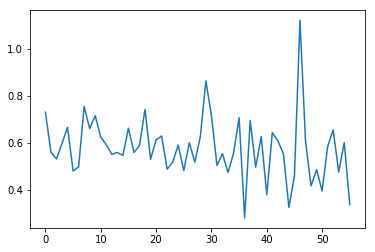

In [171]:
plt.plot(losses)
plt.show()

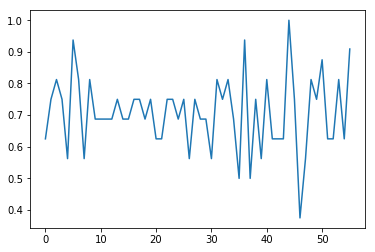

In [172]:
plt.plot(accuracy)
plt.show()

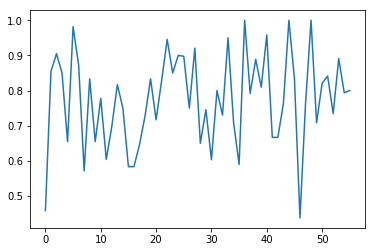

In [173]:
plt.plot(roc_auc)
plt.show()

## Задачи

1. Как вы могли увидеть, мы учим только одну эпоху, это всего 60 батчей. Попробуйте уменьшить batch_size и сделать обучение в 10-15 эпох.
2. Скорее всего мы очень быстро переобучимся. Давайте разобьем таблицу с титаником на train и validate, чтобы учиться на train и проверять переобучение и качество на validate.
3. Теперь давайте достанем test данные и попытаемся предсказать ответ для них. Допишите предсказания модели в таблицу и отправьте на kaggle чтобы посмотреть качество
4. Теперь давайте попробуем использовать на этих данных какие-нибудь другие штуки для предсказания. Попробуйте обучить LightGBM на этих фичах и посмотрите его качество. (если останется время, я расскажу про это)